<a href="https://colab.research.google.com/github/utegenf/image_classification/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2
! unzip comic-faces-paired-synthetic-v2.zip

Streaming output truncated to the last 5000 lines.
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5503.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5504.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5505.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5506.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5507.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5508.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5509.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/551.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5510.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5511.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5512.jpg  
  in

In [1]:
!rm -rf face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples
!ls face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/

comics	faces


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_dir = '/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela'

In [10]:
batch_size = 64
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

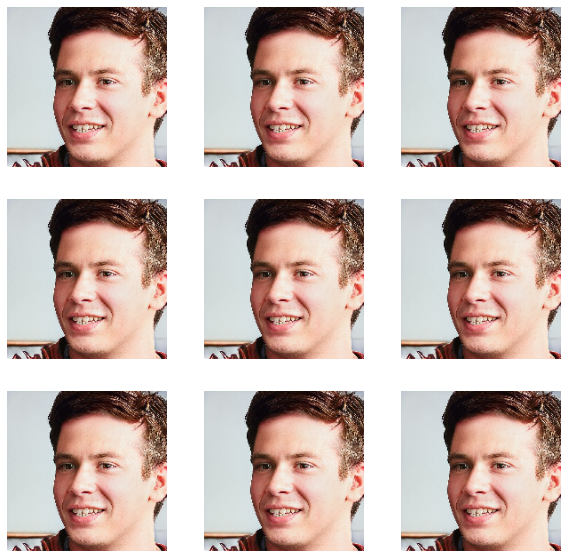

In [15]:
class_names = train_ds.class_names

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [18]:
epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
250/250 [==============================] - 647s 3s/step - loss: 0.0673 - accuracy: 0.9757 - val_loss: 0.0365 - val_accuracy: 0.9920
Epoch 2/5
250/250 [==============================] - 651s 3s/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.0945 - val_accuracy: 0.9747
Epoch 3/5
250/250 [==============================] - 651s 3s/step - loss: 0.0039 - accuracy: 0.9986 - val_loss: 0.0117 - val_accuracy: 0.9980
Epoch 4/5
250/250 [==============================] - 647s 3s/step - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.0307 - val_accuracy: 0.9950
Epoch 5/5
250/250 [==============================] - 648s 3s/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0126 - val_accuracy: 0.9975


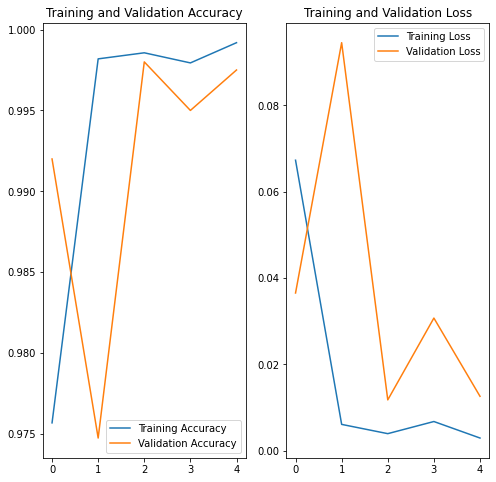

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

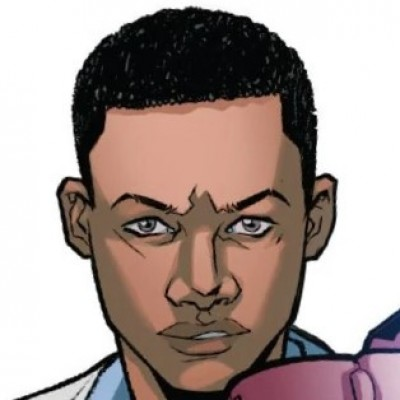

In [48]:
comic_url = "https://s3.amazonaws.com/comicgeeks/characters/avatars/20921.jpg"
comic_path = tf.keras.utils.get_file('20921', origin=comic_url)

import IPython
IPython.display.Image(comic_url, width = 250)

In [50]:
img = tf.keras.utils.load_img(
    comic_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to comics with a 71.11 percent confidence.


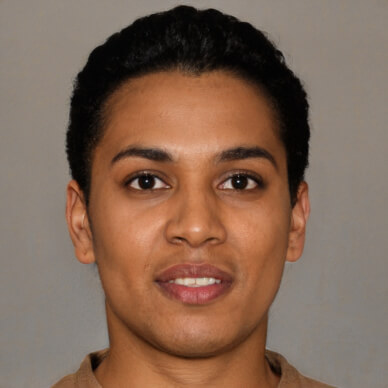

In [51]:
face_url = "https://static.generated.photos/vue-static/face-generator/landing/wall/12.jpg"
face_path = tf.keras.utils.get_file('12', origin=face_url)

import IPython
IPython.display.Image(face_url, width = 250)

In [52]:
img1 = tf.keras.utils.load_img(
    face_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img1)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to faces with a 80.46 percent confidence.
